<a href="https://colab.research.google.com/github/valentingarnier/RecommenderSystem/blob/master/Sena_Stats_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tools Installation

In [0]:
from __future__ import print_function

import pandas as pd
pd.__version__

import re
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Surprise Library

In [0]:
#Setup for surprise
!pip install scikit-surprise

     |████████████████████████████████| 6.5MB 5.8MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1678227 sha256=c0c783adf11572b4532d01bf93f7b53c0dab5358a4cd8a61d998c7213e66b3de
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [0]:
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise.model_selection import GridSearchCV

# Work on Data

In [0]:
data = pd.read_csv("/content/drive/My Drive/ML_project_recommanders/Datasets/data_train.csv")
print(data.head)

sample = pd.read_csv("/content/drive/My Drive/ML_project_recommanders/Datasets/sample_submission.csv")

<bound method NDFrame.head of                    Id  Prediction
0              r44_c1           4
1              r61_c1           3
2              r67_c1           4
3              r72_c1           3
4              r86_c1           5
...               ...         ...
1176947   r9990_c1000           4
1176948   r9992_c1000           5
1176949   r9994_c1000           3
1176950   r9997_c1000           4
1176951  r10000_c1000           3

[1176952 rows x 2 columns]>


In [0]:
#Surprise has a function that takes a dataset from a pandas dataframe.
# However, it is required that the dataframe has the form:
#3 columns [userid, movieid, rating]
#So we need to adapt the data csv given to the previous format.

In [0]:
#We have something of the form user1_movie1 rating1_1

## Reformat Data

In [0]:
cleanedFrame = pd.DataFrame({
    'userId': data["Id"].apply(lambda x: int(re.search('r(.*)_' , x).group(1))),
    'movieId': data["Id"].apply(lambda x: int(re.search('c(.*)' , x).group(1))),
    'rating' : data["Prediction"]
})

print(cleanedFrame.head)


sampleFrame = pd.DataFrame({
    'userId': sample["Id"].apply(lambda x: int(re.search('r(.*)_' , x).group(1))),
    'movieId': sample["Id"].apply(lambda x: int(re.search('c(.*)' , x).group(1))),
    'rating' : sample["Prediction"]
})

print(sampleFrame.head)

<bound method NDFrame.head of          userId  movieId  rating
0            44        1       4
1            61        1       3
2            67        1       4
3            72        1       3
4            86        1       5
...         ...      ...     ...
1176947    9990     1000       4
1176948    9992     1000       5
1176949    9994     1000       3
1176950    9997     1000       4
1176951   10000     1000       3

[1176952 rows x 3 columns]>
<bound method NDFrame.head of          userId  movieId  rating
0            37        1       3
1            73        1       3
2           156        1       3
3           160        1       3
4           248        1       3
...         ...      ...     ...
1176947    9974     1000       3
1176948    9977     1000       3
1176949    9978     1000       3
1176950    9982     1000       3
1176951    9996     1000       3

[1176952 rows x 3 columns]>


## Exploratory Data Analysis

### Data Shape

In [0]:
print('Number of given ratings: ' + str(data.shape[0]))

Number of given ratings: 1176952


In [0]:
matrix_size = 10000*1000
print('Percentage of missing entries: ' + str(round((1 - data.shape[0]/matrix_size)*100, 2)) + '%')

Percentage of missing entries: 88.23%


### Ratings Given Statistics

In [0]:
print('userId with the highest number of ratings, respectively: ' + str(cleanedFrame['userId'].value_counts()[0:1]))

userId with the highest number of ratings, respectively: 5512    522
Name: userId, dtype: int64


In [0]:
print('userId with the fewest number of ratings, respectively: ' + str(cleanedFrame['userId'].value_counts()[-1:]))

userId with the fewest number of ratings, respectively: 481    3
Name: userId, dtype: int64


In [0]:
print('Average number of ratings given by a user: ' + str(round(cleanedFrame.groupby(['userId']).size().mean(), 1)))

Average number of ratings given by a user: 117.7


In [0]:
print('Median number of ratings given by a user: ' + str(round(cleanedFrame.groupby(['userId']).size().median(), 1)))

Median number of ratings given by a user: 104.0


In [0]:
# Plots a histogram with given parameters, i.e. dataframe, number of bins, title, xlabel, and ylabel
def plot_hist(df, bins, title, xlabel, ylabel):
  hist = df.hist(bins=bins)
  hist.set_title(title)
  hist.set_xlabel(xlabel)
  hist.set_ylabel(ylabel)  
  hist.figure

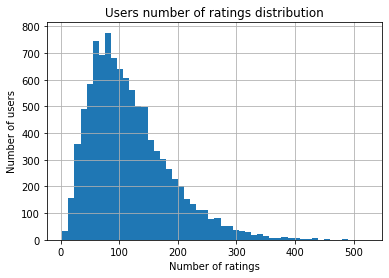

In [0]:
user_ratings_counts = cleanedFrame['userId'].value_counts()[0:10000]
plot_hist(user_ratings_counts, 50, 'Users number of ratings distribution', 'Number of ratings', 'Number of users')

>We observe a right-skewed distribution, where the median is smaller than the mean. This means that a small number of users give an excessive amount of ratings than the others. 

### Ratings Received Statistics

In [0]:
print('movieId with the highest number of ratings, respectively: ' + str(cleanedFrame['movieId'].value_counts()[0:1]))

movieId with the highest number of ratings, respectively: 178    4590
Name: movieId, dtype: int64


In [0]:
print('movieId with the fewest number of ratings, respectively: ' + str(cleanedFrame['movieId'].value_counts()[-1:]))

movieId with the fewest number of ratings, respectively: 955    8
Name: movieId, dtype: int64


In [0]:
print('Average number of ratings given to a movie: ' + str(round(cleanedFrame.groupby(['movieId']).size().mean(), 1)))

Average number of ratings given to a movie: 1177.0


In [0]:
print('Median number of ratings given to a movie: ' + str(round(cleanedFrame.groupby(['movieId']).size().median(), 1)))

Median number of ratings given to a movie: 883.5


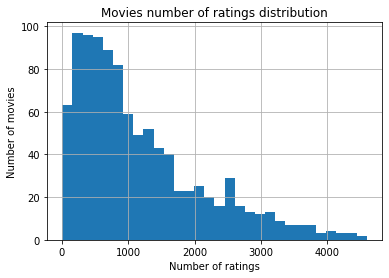

In [0]:
movie_ratings_counts = cleanedFrame['movieId'].value_counts()[0:100000]
plot_hist(movie_ratings_counts, 30, 'Movies number of ratings distribution', 'Number of ratings', 'Number of movies')

>We again observe a right-skewed distribution, where the median is smaller than the mean. This means that a small number of movies get an excessive amount of ratings than the rest of the movies. 

### User Average Rating Statistics

In [0]:
print('Highest user average: ' + str(round(cleanedFrame.groupby(['userId'])['rating'].mean().max(), 2)))

Highest user average: 4.93


In [0]:
print('Lowest user average: ' + str(round(cleanedFrame.groupby(['userId'])['rating'].mean().min(), 2)))

Lowest user average: 1.85


In [0]:
print('Mean user average: ' + str(round(cleanedFrame.groupby(['userId'])['rating'].mean().mean(), 2)))

Mean user average: 3.83


In [0]:
print('Median user average rating: ' + str(round(cleanedFrame.groupby(['userId'])['rating'].mean().median(), 2)))

Median user average rating: 3.85


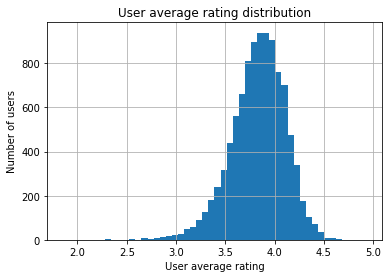

In [0]:
user_avg_ratings = cleanedFrame.groupby(['userId'])['rating'].mean()
plot_hist(user_avg_ratings, 50, 'User average rating distribution', 'User average rating', 'Number of users')

>We observe a normal distribution with a slight left skew. We can deduce that average ratings differ from user to user with a range of 1.85 to 4.93.

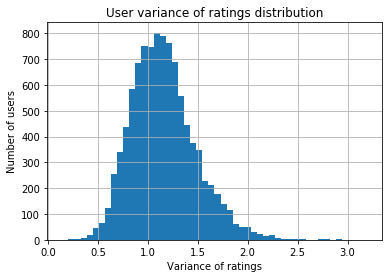

In [0]:
user_var_ratings = cleanedFrame.groupby('userId')['rating'].var()
plot_hist(user_var_ratings, 50, 'User variance of ratings distribution', 'Variance of ratings', 'Number of users')

>We observe no spammers in our data, i.e. users give varying ratings to different movies.

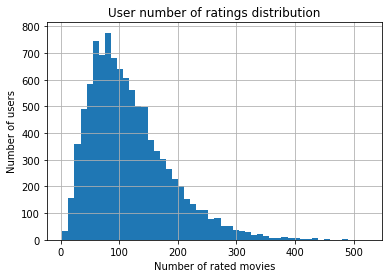

In [0]:
user_num_rated_movies = cleanedFrame.groupby('userId')['rating'].count()
plot_hist(user_num_rated_movies, 50, 'User number of ratings distribution', 'Number of rated movies', 'Number of users')

>We observe good participation of the users.

### Movie Average Rating Statistics

In [0]:
print('Highest movie average: ' + str(round(cleanedFrame.groupby(['movieId'])['rating'].mean().max(), 2)))

Highest movie average: 4.73


In [0]:
print('Lowest movie average: ' + str(round(cleanedFrame.groupby(['movieId'])['rating'].mean().min(), 2)))

Lowest movie average: 2.02


In [0]:
print('Mean movie average: ' + str(round(cleanedFrame.groupby(['movieId'])['rating'].mean().mean(), 2)))

Mean movie average: 3.6


In [0]:
print('Median movie average rating: ' + str(round(cleanedFrame.groupby(['movieId'])['rating'].mean().median(), 2)))

Median movie average rating: 3.62


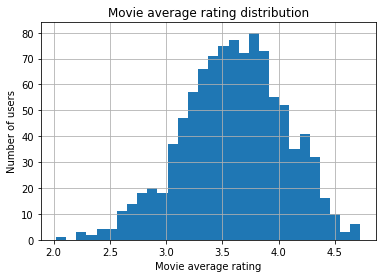

In [0]:
movie_avg_ratings = cleanedFrame.groupby(['movieId'])['rating'].mean()
plot_hist(movie_avg_ratings, 30, 'Movie average rating distribution', 'Movie average rating', 'Number of users')

>We observe a normal distribution with a slight left skew. We can deduce that average ratings differ from movie to movie with a range of 2.02 to 4.73.

### Rating Statistics

In [0]:
print('Average of all ratings: ' + str(round(cleanedFrame['rating'].mean(), 2)))

Average of all ratings: 3.86


In [0]:
print('Median of all ratings: ' + str(cleanedFrame['rating'].median()))

Median of all ratings: 4.0


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
ratings = pd.DataFrame(cleanedFrame.groupby('movieId')['rating'].mean())
ratings.head()

,rating
movieId,
1,3.379412
2,3.500942
3,3.483586
4,3.936473
5,3.559131


In [0]:
ratings['num of ratings'] = pd.DataFrame(cleanedFrame.groupby('movieId')['rating'].count())
ratings.head()

,rating,num of ratings
movieId,,
1,3.379412,340
2,3.500942,531
3,3.483586,792
4,3.936473,3164
5,3.559131,1243


Text(0.5, 0.98, 'Movie Ratings vs. Number of Ratings')

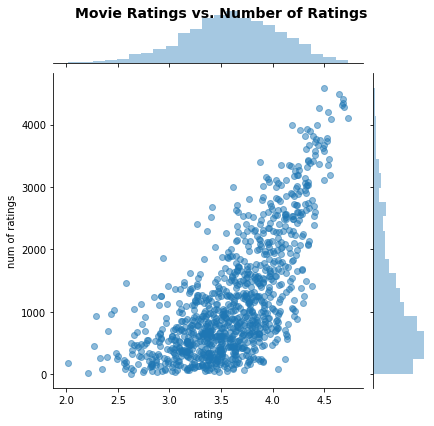

In [0]:
pp = sns.jointplot(x='rating', y='num of ratings', data=ratings, alpha=0.5)
fig = pp.fig
fig.suptitle('Movie Ratings vs. Number of Ratings', fontsize=14, fontweight='bold')

## Surprise preparation

In [0]:
reader = Reader(rating_scale=(1, 5))

#Here we call surprise function 

dataCleaned = Dataset.load_from_df(cleanedFrame[['userId', 'movieId', 'rating']], reader)
sampleCleaned = Dataset.load_from_df(sampleFrame[['userId', 'movieId', 'rating']], reader)

# Models & Algorithms

In [0]:
#Compute training set and final testset

trainset = dataCleaned.build_full_trainset()
testset = sampleCleaned.build_full_trainset().build_testset() #Compute from sample submission which is the testset

## SVD

In [0]:
from surprise import SVD
from surprise.model_selection import train_test_split

### Grid Search

In [0]:
param_grid = {'n_factors': [1, 2, 3, 4, 5], 'lr_all': [0.5, 0.1, 0.05, 0.02, 0.01, 0.0015],
              'reg_all': [0.01, 0.1, 0.5, 0.05, 0.002, 1], 'biased': [True, False]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)

gs.fit(dataCleaned) #Need raw ratings

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

### Training phase

In [0]:
trainset1, testset1 = train_test_split(dataCleaned, test_size=0.3)

In [0]:
#Apply best parameters from gridSearch

algo = gs.best_estimator['rmse'] #Take the best parameters computed by gs, the gridSearch
algo.fit(trainset1)

predictions1 = algo.test(testset1)
accuracy.rmse(predictions1) #Rely on this accuracy, based on real data from given training data.

### Apply SVD on test set

In [0]:
#Run ici seulement si on a trouvé les meilleurs param pour algo

predictions = algo.test(testset) #final prediction on final test set.
accuracy.rmse(predictions, verbose=True) #Don't rely on this, ratings are all 3 in testset, not accurate. Rather do a split with the trainingset.

### Output Frame

In [0]:
#Now we need to rebuild a dataframe so that it fits sample_submission.csv for putting it on aicrowd.
#Predictions should contain all the prediction, not just on test set.
predictions = np.asarray(predictions)

d = []

for p in predictions:
    d.append(("r"+str(p[0])+"_c"+str(p[1]), np.round(p[3])))

result_svd = pd.DataFrame(d, columns = ('Id', 'Prediction'))
print(result_svd.head)

In [0]:
result_svd.to_csv("result_svd.csv", index=False)

## SVD ++

SVD++ takes time around 3 hours

In [0]:
from surprise import SVDpp

In [0]:
#Apply best parameters from gridSearch

algo = SVDpp()
algo.fit(trainset)

In [0]:
predictions_svdpp = algo.test(testset)
accuracy.rmse(predictions_svdpp, verbose=True)

In [0]:
predictions_svdpp = np.asarray(predictions_svdpp)

d = []

for p in predictions_svdpp:
    d.append(("r"+str(p[0])+"_c"+str(p[1]), np.round(p[3])))

result_svdpp = pd.DataFrame(d, columns = ('Id', 'Prediction'))
print(result_svdpp.head)

In [0]:
result_svdpp.to_csv("result_svdpp.csv", index=False)

## KNN Basic


In [0]:
from surprise import KNNBaseline

In [0]:
algo = KNNBaseline()
algo.fit(trainset)

In [0]:
predictions_knn = algo.test(testset)
accuracy.rmse(predictions_knn, verbose=True)

In [0]:
predictions_knn = np.asarray(predictions_knn)

d = []

for p in predictions_knn:
    d.append(("r"+str(p[0])+"_c"+str(p[1]), np.round(p[3])))

result_knn = pd.DataFrame(d, columns = ('Id', 'Prediction'))
print(result_knn.head)

In [0]:
result_knn.to_csv("result_knn.csv", index=False)

## Slope One

In [0]:
from surprise import SlopeOne

In [0]:
algo = SlopeOne()
algo.fit(trainset)

In [0]:
predictions_slope = algo.test(testset)
accuracy.rmse(predictions_slope, verbose=True)

In [0]:
predictions_slope = np.asarray(predictions_slope)

d = []

for p in predictions_slope:
    d.append(("r"+str(p[0])+"_c"+str(p[1]), np.round(p[3])))

result_slope = pd.DataFrame(d, columns = ('Id', 'Prediction'))
print(result_slope.head)

In [0]:
result_slope.to_csv("result_slope.csv", index=False)

## Co-Clustering

In [0]:
from surprise import CoClustering

In [0]:
algo = CoClustering()
algo.fit(trainset)

In [0]:
predictions_co = algo.test(testset)
accuracy.rmse(predictions_co, verbose=True)

In [0]:
predictions_co = np.asarray(predictions_co)

d = []

for p in predictions_co:
    d.append(("r"+str(p[0])+"_c"+str(p[1]), np.round(p[3])))

result_co = pd.DataFrame(d, columns = ('Id', 'Prediction'))
print(result_co.head)

In [0]:
result_co.to_csv("result_co.csv", index=False)